In [1]:
##   Project: Action Recognition using CNN + LSTM (UCF50 - 18 classes)
##  Goal: Classify videos based on actions using deep learning (TimeDistributed CNN + LSTM)
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.optimizers import Adam

2025-11-29 18:03:53.763992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764439434.022170   16828 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764439434.101778   16828 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

DIRECTORY="/kaggle/input/anomalous-action-detection-dataset/Anomalous Action Detection Dataset( Ano-AAD)/abnormal class"
NORMAL_DIRECTORY="/kaggle/input/anomalous-action-detection-dataset/Anomalous Action Detection Dataset( Ano-AAD)/normal class - normal videos"
dataset_path = os.listdir(DIRECTORY)

label_types = os.listdir(DIRECTORY)
print (label_types)  

label_types_Normal = os.listdir(NORMAL_DIRECTORY)
print (label_types_Normal)  
selected_classes=label_types+label_types_Normal
selected_classes

['Arrest', 'Ill-treatment', 'Explosion', 'violence', 'Traffic Irregularities', 'Attack', 'Burglary', 'Fighting', 'fire-raising']
['Normal Videos']


['Arrest',
 'Ill-treatment',
 'Explosion',
 'violence',
 'Traffic Irregularities',
 'Attack',
 'Burglary',
 'Fighting',
 'fire-raising',
 'Normal Videos']

In [3]:
rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir(DIRECTORY + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append(( str(DIRECTORY + '/' +item) + '/' + room,item))

for item in label_types_Normal:
 # Get all the file names
 all_rooms = os.listdir(NORMAL_DIRECTORY + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append(( str(NORMAL_DIRECTORY + '/' +item) + '/' + room,item))
    
# Build a dataframe        
train_df = pd.DataFrame(data=rooms, columns=[ 'video_path','label'])
print(train_df.head())
print(train_df.tail())

                                          video_path   label
0  /kaggle/input/anomalous-action-detection-datas...  Arrest
1  /kaggle/input/anomalous-action-detection-datas...  Arrest
2  /kaggle/input/anomalous-action-detection-datas...  Arrest
3  /kaggle/input/anomalous-action-detection-datas...  Arrest
4  /kaggle/input/anomalous-action-detection-datas...  Arrest
                                            video_path          label
390  /kaggle/input/anomalous-action-detection-datas...  Normal Videos
391  /kaggle/input/anomalous-action-detection-datas...  Normal Videos
392  /kaggle/input/anomalous-action-detection-datas...  Normal Videos
393  /kaggle/input/anomalous-action-detection-datas...  Normal Videos
394  /kaggle/input/anomalous-action-detection-datas...  Normal Videos


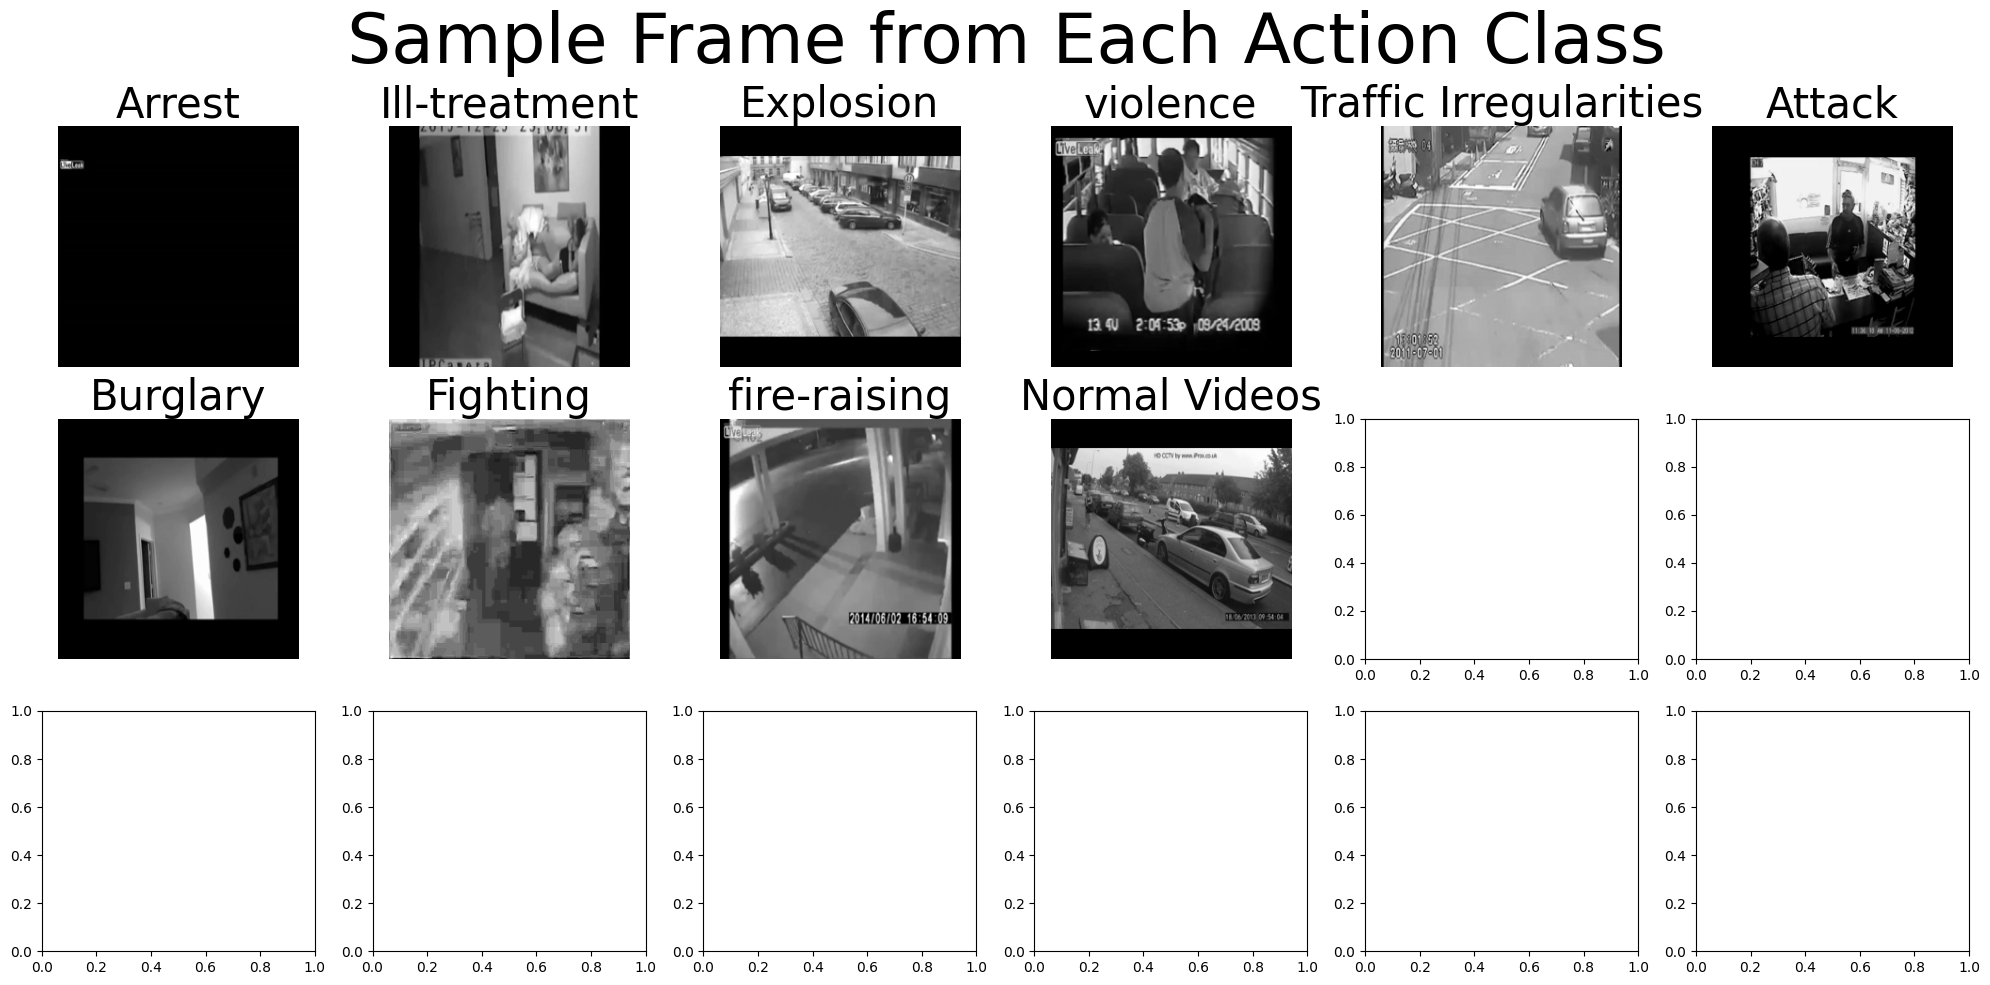

In [4]:
# Show 1 frame from 1 video of each class

def show_sample_frames(classes, dataset_path):
    fig, axes = plt.subplots(3, 6, figsize=(20, 10))  # 3 rows and 6 columns
    axes = axes.flatten()  # make it easy to loop over

    for i, cls in enumerate(classes):
        # Load first video from the class folder
        if(cls=="Normal Videos"):
            video_path = os.path.join(NORMAL_DIRECTORY, cls, os.listdir(os.path.join(NORMAL_DIRECTORY, cls))[0])
        else:
            video_path = os.path.join(dataset_path, cls, os.listdir(os.path.join(dataset_path, cls))[0])
        cap = cv2.VideoCapture(video_path) #think of cap like a video player that's paused and ready to play frame by frame.

        # ret: a boolean (True/False) — it’s True if a frame was read successfully
        # frame: the actual image/frame (as a NumPy array)
        ret, frame = cap.read()
        cap.release() # This closes the video file after you're done

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.resize(frame, (256, 256))
            axes[i].imshow(frame, cmap='gray')
            axes[i].set_title(cls, fontsize=30)
        axes[i].axis('off')
             

    plt.suptitle(" Sample Frame from Each Action Class", fontsize=50)
    plt.tight_layout()
    plt.show()

# Calling
show_sample_frames(selected_classes, DIRECTORY)


In [5]:
#  Extract fixed number of frames from each video
# For simplicity and speed, we’ll extract 20 frames per video

def extract_frames(video_path, num_frames=40):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(total_frames // num_frames, 1)
    
    count = 0
    while len(frames) < num_frames and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % frame_interval == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (64, 64))
            # frame = np.expand_dims(frame, axis=0) # Add channel dimension
            frame = frame / 255.0  # Normalize pixel values
            frames.append(frame)
        count += 1
    cap.release()

    # Pad with last frame if video too short
    while len(frames) < num_frames:
        frames.append(frames[-1])
    
    return np.array(frames)


In [6]:
# Loop through videos in selected classes and extract frames
X = []
y = []

for class_index, cls in enumerate(selected_classes):
    if(cls=="Normal Videos"):
        class_path = os.path.join(NORMAL_DIRECTORY, cls)
        videos = os.listdir(class_path)  
    else:
        class_path = os.path.join(DIRECTORY, cls)
        videos = os.listdir(class_path)  
    for video in videos:
        video_path = os.path.join(class_path, video)
        frames = extract_frames(video_path, num_frames=40)
        if frames.shape == (40, 64, 64,3):  # Ensure consistent shape
            X.append(frames)
            y.append(class_index)


In [7]:

X = np.array(X)
y = to_categorical(y) # One-Hot

print(" Data Loaded:")
print("X shape:", X.shape)  # (samples, time_steps, height, width, channels)
print("y shape:", y.shape)  # (samples, num_classes)


 Data Loaded:
X shape: (395, 40, 64, 64, 3)
y shape: (395, 10)


In [8]:
print("y shape:", y.shape) 

y shape: (395, 10)


In [9]:
#  Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training videos:", X_train.shape[0])
print("Testing videos:", X_test.shape[0])


Training videos: 316
Testing videos: 79


In [10]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# model = Sequential()

# # CNN feature extractor applied frame-wise (spatial features)
# model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'),
#                           input_shape=(40, 64, 64, 3)))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
# model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
# model.add(TimeDistributed(Flatten()))

# # LSTM for temporal feature extraction (temporal features)
# model.add(LSTM(64, return_sequences=False))
# model.add(Dropout(0.5))

# # Final classification layer
# model.add(Dense(len(selected_classes), activation='softmax'))

# # Compile the model
# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(learning_rate=0.003),
#               metrics=['accuracy'])

# # Freeze CNN feature extractor layers if needed
# for layer in model.layers[:4]:
#     layer.trainable = False


In [51]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, Dropout, Flatten

input_shape = (40, 64, 64, 3)
frame_input = Input(shape=input_shape)

# Base model for feature extraction
base_model = EfficientNetB0(include_top=False, weights='/kaggle/input/model1/other/default/1/efficientnetb0_notop.h5', input_shape=(64,64,3), pooling='avg')

# TimeDistributed wrapper
x = TimeDistributed(base_model)(frame_input)
x = LSTM(64)(x)
x = Dropout(0.5)(x)
output = Dense(len(selected_classes), activation='softmax')(x)

model = Model(inputs=frame_input, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 20, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 1280)       │     4,049,571 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │       344,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,394,541 (16.76 MB)

 Trainable params: 4,352,518 (16.60 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications import EfficientNetB0

base = EfficientNetB0(include_top=False, weights='/kaggle/input/model1/other/default/1/efficientnetb0_notop.h5', input_shape=(64,64,3), pooling='avg')


# base = DenseNet121(include_top=False, weights='/kaggle/input/densnet/other/default/1/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', pooling=None, input_shape=(64, 64, 3))

model = Sequential()
model.add(TimeDistributed(base, input_shape=(40, 64, 64, 3)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(len(selected_classes), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# for layer in base.layers:
#     layer.trainable = False
# for layer in base.layers[:-20]:
#     layer.trainable = False
# for layer in base.layers[-20:]:
#     layer.trainable = True



2025-11-29 18:11:48.058457: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, Dropout, Flatten, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf

# Feature Extraction: Lightweight EfficientNet-Lite backbone
base = EfficientNetB0(
    include_top=False,
    weights='/kaggle/input/model1/other/default/1/efficientnetb0_notop.h5',
    # weights=None,
    input_shape=(64, 64, 3),
    pooling='avg'
)
for layer in base.layers:
    layer.trainable = True  # optionally freeze some layers for transfer learning

# Temporal Modeling: Using LSTM for sequential data or MultiHeadAttention for temporal relationships
def temporal_attention_module(inputs, num_heads=4, ff_dim=64):
    x = LayerNormalization()(inputs)
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x, x)
    x = x + attention_output  # residual connection
    x = LayerNormalization()(x)
    x = Dense(ff_dim, activation='relu')(x)
    return x

video_input = Input(shape=(40, 64, 64, 3))
x = TimeDistributed(base)(video_input)
x = TimeDistributed(Flatten())(x)
x = temporal_attention_module(x)  # optional transformer-based temporal attention
x = LSTM(64, return_sequences=False)(x)
x = Dropout(0.5)(x)
output = Dense(len(selected_classes), activation='softmax')(x)

model = Model(inputs=video_input, outputs=output)

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.003),
    metrics=['accuracy']
)

# Explainability: Grad-CAM integration
def get_gradcam_heatmap(model, video_frame, class_index):
    grad_model = Model([model.inputs], [model.get_layer(index=-3).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(video_frame)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)
    return heatmap


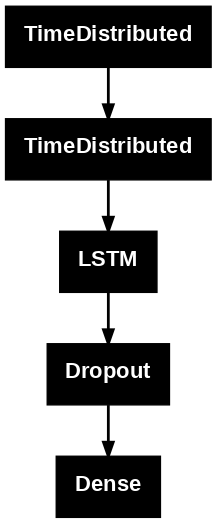

In [11]:
plot_model(model,dpi=100)

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 40, 1280)       │     4,049,571 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 40, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       344,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,394,541 (16.76 MB)

 Trainable params: 4,352,518 (16.60 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
#  Train the model
# X_train.shape 
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=16)


Epoch 1/20


In [18]:
import tensorflow as tf
import numpy as np 
import cv2
import   matplotlib.pyplot as plt

def get_gradcam_heatmap(model, frame, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.layers[0].input,
        outputs=[model.get_layer("time_distributed").layer.get_layer(last_conv_layer_name).output,
                 model.output]
    )

    frame = np.expand_dims(frame, axis=0)
    frame = np.expand_dims(frame, axis=0)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(frame)
        pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    cam = np.zeros(conv_outputs.shape[:2], dtype=np.float32)
    for i, w in enumerate(pooled_grads):
        cam += w * conv_outputs[:, :, i]

    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    cam = cv2.resize(cam, (64, 64))

    return cam, int(pred_index)


In [19]:
def visualize_gradcam_video(model, video, class_names):
    mid_frame = video[len(video)//2]
    heatmap, pred_idx = get_gradcam_heatmap(model, mid_frame, "conv5_block16_2_conv")

    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    frame_uint8 = (mid_frame * 255).astype(np.uint8)
    overlay = cv2.addWeighted(frame_uint8, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(8,5))
    plt.imshow(overlay)
    plt.title(f"Predicted: {class_names[pred_idx]}")
    plt.axis("off")
    plt.show()


In [20]:
# idx = np.random.randint(0, len(X_test))
# visualize_gradcam_video(model, X_test[idx], selected_classes)


ValueError: No such layer: time_distributed. Existing layers are: ['input_layer_5', 'time_distributed_4', 'time_distributed_5', 'layer_normalization_4', 'multi_head_attention_2', 'layer_normalization_5', 'dense_3', 'lstm_2', 'dropout_5', 'dense_4'].

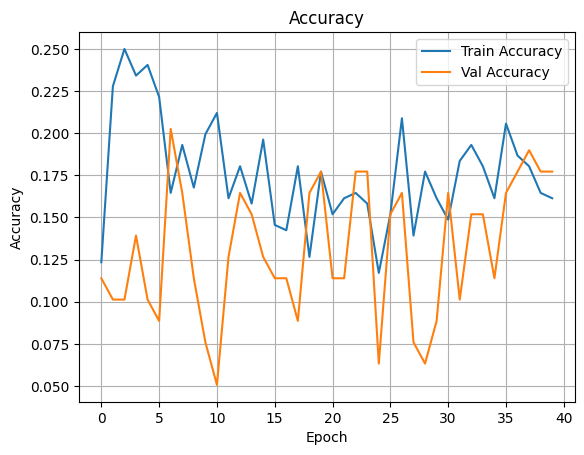

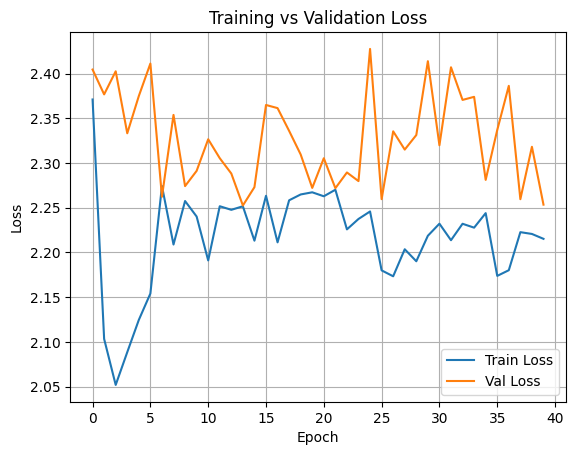

In [21]:
#  Training vs Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()    
plt.grid(True)
plt.show()

#  Training vs Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 411s 102s/step


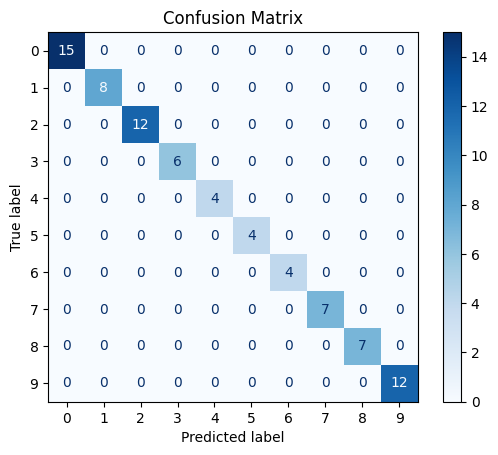

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get model predictions on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_test, axis=1)  # if it's a classification model
y_true = np.argmax(y_test, axis=1)          # if y_test is one-hot encoded

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


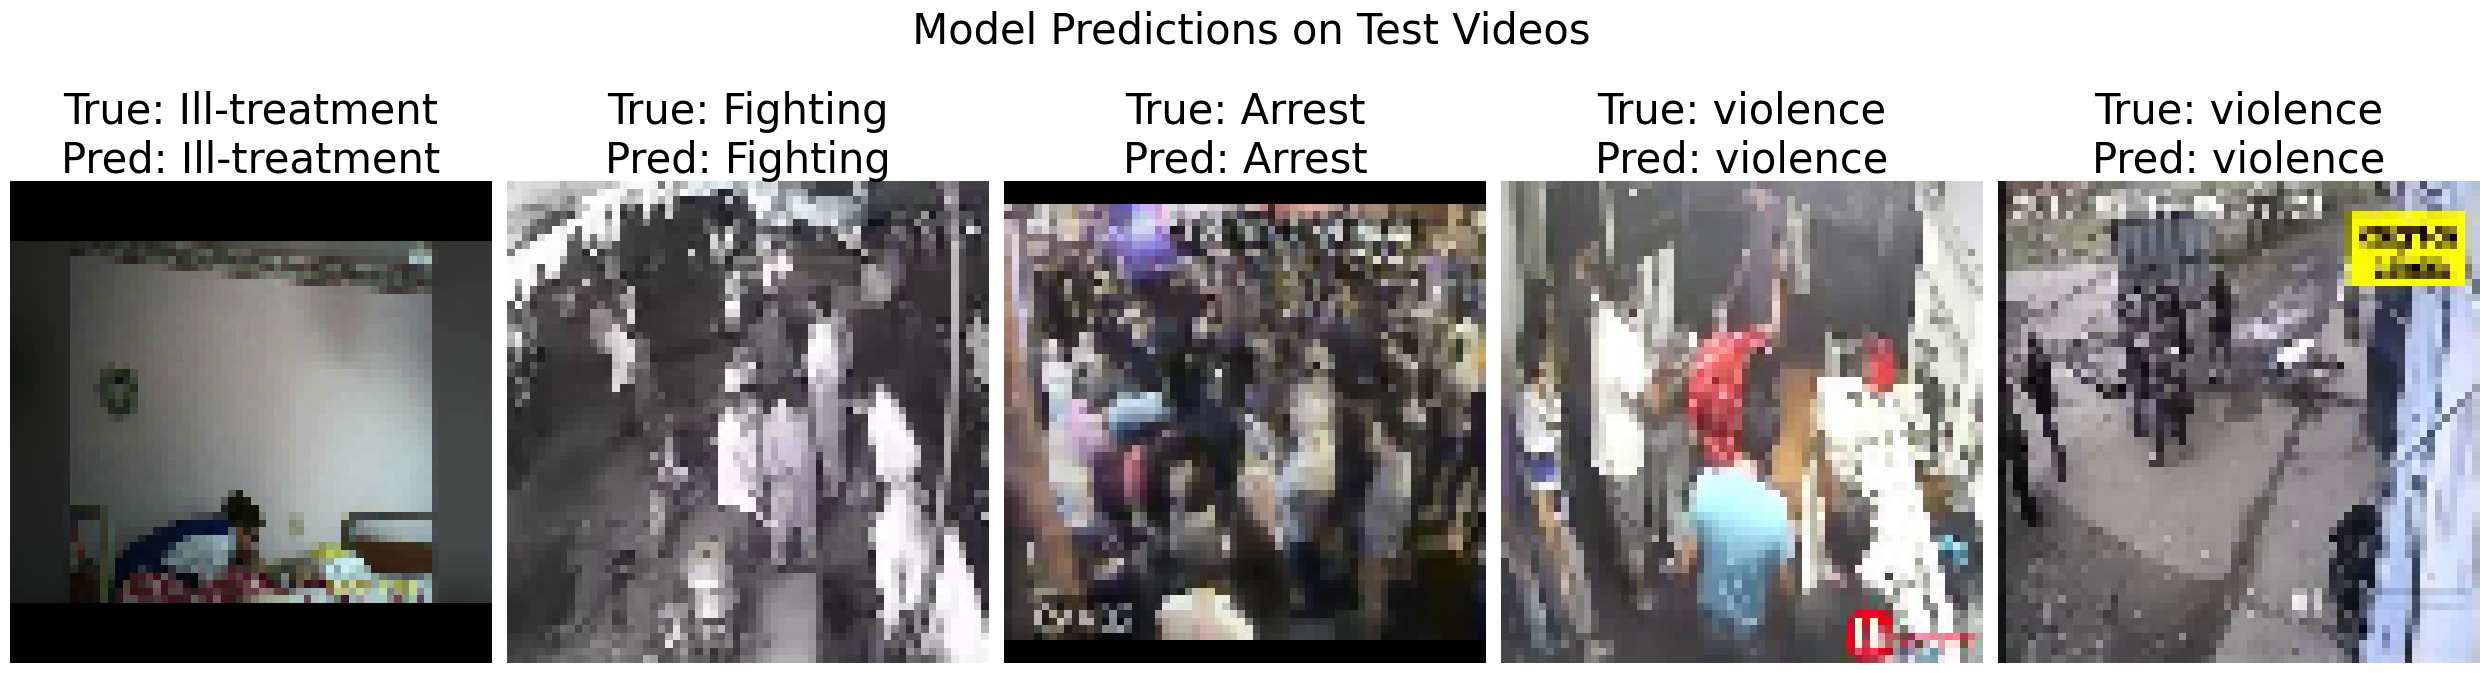

In [32]:
#  Visualize model predictions on 5 test videos (larger images)
def show_predictions(model, X_test, y_test, class_names):
    # Get 5 random indices
    indices = np.random.choice(len(X_test), 5, replace=False)
    
    # Bigger canvas size
    fig, axes = plt.subplots(1, 5, figsize=(25, 8))  #  Wider and taller

    for i, idx in enumerate(indices):
        video = X_test[idx]
        true_label = class_names[np.argmax(y_test[idx])]

        # Predict
        prediction = model.predict(np.expand_dims(video, axis=0), verbose=0)
        predicted_label = class_names[np.argmax(prediction)]

        # Get middle frame and denormalize
        mid_frame = video[len(video) // 2]
        mid_frame = (mid_frame * 255).astype(np.uint8)

        # Optional: remove resizing if frame is already big enough
        # frame = cv2.resize(mid_frame, (256, 256))  # or skip this
        frame = mid_frame  # Show full original frame size

        # Plot
        axes[i].imshow(frame)
        axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}", fontsize=30)
        axes[i].axis('off')

    plt.suptitle(" Model Predictions on Test Videos", fontsize=30)
    plt.tight_layout()
    plt.show()

#  Run it
show_predictions(model, X_train, y_train, selected_classes)


In [27]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Convert predictions and labels back to class indices
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print overall accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print("Overall Accuracy:", accuracy)

# Print precision, recall, and F1-score for each class
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes))


3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step
Overall Accuracy: 0.21518987341772153

Classification Report:

              precision    recall  f1-score   support

           0       0.10      0.07      0.08        15
           1       0.17      0.12      0.14         8
           2       0.44      0.33      0.38        12
           3       0.00      0.00      0.00         6
           4       1.00      0.50      0.67         4
           5       0.00      0.00      0.00         4
           6       0.08      0.25      0.12         4
           7       0.14      0.29      0.19         7
           8       0.45      0.71      0.56         7
           9       0.12      0.08      0.10        12

    accuracy                           0.22        79
   macro avg       0.25      0.24      0.22        79
weighted avg       0.23      0.22      0.21        79



3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step
Overall Accuracy: 0.21518987341772153

Classification Report:

              precision    recall  f1-score   support

           0       0.10      0.07      0.08        15
           1       0.17      0.12      0.14         8
           2       0.44      0.33      0.38        12
           3       0.00      0.00      0.00         6
           4       1.00      0.50      0.67         4
           5       0.00      0.00      0.00         4
           6       0.08      0.25      0.12         4
           7       0.14      0.29      0.19         7
           8       0.45      0.71      0.56         7
           9       0.12      0.08      0.10        12

    accuracy                           0.22        79
   macro avg       0.25      0.24      0.22        79
weighted avg       0.23      0.22      0.21        79



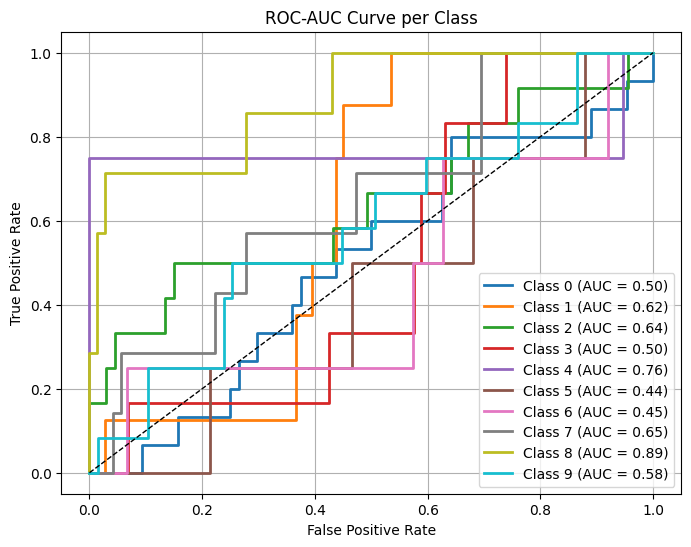

Overall Macro ROC-AUC: 0.6040


In [23]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# === Performance Metrics ===
print("Overall Accuracy:", accuracy_score(y_true, y_pred_classes))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes))

# === AUC (per class and micro/macro averages) ===
n_classes = y_test.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# === Plot AUC Curve ===
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('ROC-AUC Curve per Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# === Overall ROC-AUC ===
overall_auc = roc_auc_score(y_test, y_pred, average='macro')
print(f"Overall Macro ROC-AUC: {overall_auc:.4f}")
